In [2]:
library(jsonlite)
library(plyr)
library(dplyr)
library(ggplot2)

setwd("/home/hduser1/Yelp")
business = stream_in(file("biz_corrected.json"))
biz_food = stream_in(file("biz_food.json"))
review = stream_in(file("review.json"))
review_food = review[which(review$business_id %in% biz_food$business_id),]
stream_out(review_food, file("review_food.json"))

opening file input connection.


 Imported 136570 records. Simplifying...


closing file input connection.
opening file input connection.


 Imported 60702 records. Simplifying...


closing file input connection.
opening file input connection.


 Imported 4153150 records. Simplifying...


closing file input connection.
opening file output connection.


Complete! Processed total of 2874628 rows.


closing file output connection.


In [3]:
threshold = function(numReviews) {
  open = biz_food[which(biz_food$review_count >= numReviews & biz_food$is_open == 1),]
  closed = biz_food[which(biz_food$review_count >= numReviews & biz_food$is_open == 0),]
  return(nrow(open)/(nrow(open)+nrow(closed)))
}

In [4]:
findThreshold = function(x) {
  
  # percentage of business that are open at various threholds of total review number
  numReviews = c(0:x)
  percentOpen = sapply(numReviews, threshold)
  thresh = as.data.frame(cbind(numReviews,percentOpen))
  rm(numReviews, percentOpen)
  
  # fit 1/x model
  invModel = lm(1/(thresh$percentOpen-1) ~ thresh$numReviews)
  return(summary(invModel)$r.squared)
  
}

In [8]:
x = sapply(c(10:60), findThreshold)
x

[1] 0.9416161 0.9548769 0.9633853 0.9703211 0.9756877 0.9799775 0.9831605
 [8] 0.9858017 0.9878316 0.9894377 0.9906821 0.9914435 0.9917013 0.9914159
[15] 0.9914242 0.9921035 0.9926149 0.9930637 0.9936152 0.9941356 0.9946625
[22] 0.9951424 0.9955661 0.9959233 0.9960913 0.9962941 0.9964295 0.9963696
[29] 0.9962342 0.9955885 0.9949395 0.9941881 0.9931164 0.9920000 0.9906835
[36] 0.9893089 0.9877592 0.9861732 0.9849617 0.9840322 0.9835077 0.9830811
[43] 0.9827045 0.9824571 0.9825544 0.9827066 0.9832031 0.9834403 0.9839037
[50] 0.9846192 0.9851821


Call:
lm(formula = 1/(thresh$percentOpen - 1) ~ thresh$numReviews)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.099686 -0.038193 -0.005638  0.037984  0.114118 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -4.318218   0.018377 -234.98   <2e-16 ***
thresh$numReviews -0.071268   0.001168  -61.01   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04993 on 26 degrees of freedom
Multiple R-squared:  0.9931,	Adjusted R-squared:  0.9928 
F-statistic:  3722 on 1 and 26 DF,  p-value: < 2.2e-16


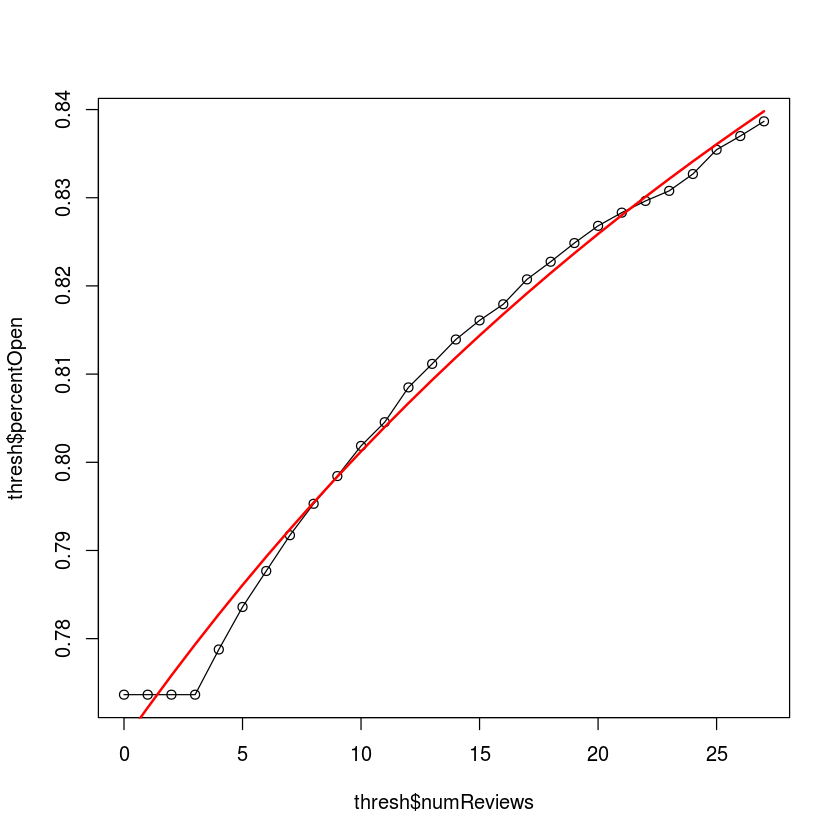

In [9]:
# find number of reviews at which R-squared value is maximum and graph fitted function
index = which.max(x)
numReviews = c(0:index)
percentOpen = sapply(numReviews, threshold)
thresh = as.data.frame(cbind(numReviews,percentOpen))
rm(numReviews, percentOpen)
invModel = lm(1/(thresh$percentOpen-1) ~ thresh$numReviews)
summary(invModel)
plot(thresh$numReviews, thresh$percentOpen, type = "o")
thresh$fitinv = predict(invModel, data = thresh)
thresh$fitted = 1+1/thresh$fitinv
lines(thresh$numReviews, thresh$fitted, lwd=2, col="red")

In [10]:
# count number of reviews for a given day - review intensity of food related reviews
# review_food = stream_in(file("review_food.json"))
perDay = plyr::count(review_food, "date")
perDay$date = as.Date(perDay$date)
perDay$day = as.numeric(perDay$date - as.Date("2004-10-12")) + 1
perDay$daydiff = c(0, diff(perDay$day))
cutoff = max(perDay$date[which(perDay$daydiff > 1)])

In [14]:
# from 2006-10-22, there is some review of a food business every day (helps with integrating fitted lambda)
perDay = perDay[which(perDay$date >= cutoff),]
perDay$day = as.numeric(perDay$date - cutoff) + 1


Call:
lm(formula = y ~ I(x) + I(x^2) + I(x^2 * sin(2 * x * pi/7)) + 
    I(x^2 * sin(2 * x * pi/182.5)) + I(x^2 * sin(2 * x * pi/365)), 
    data = perDay)

Residuals:
     Min       1Q   Median       3Q      Max 
-1169.57   -53.65    -3.07    51.59   740.56 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     2.242e+01  7.116e+00   3.151  0.00164 ** 
I(x)                            4.269e-02  8.782e-03   4.861 1.22e-06 ***
I(x^2)                          1.424e-04  2.272e-06  62.678  < 2e-16 ***
I(x^2 * sin(2 * x * pi/7))      1.593e-05  5.343e-07  29.824  < 2e-16 ***
I(x^2 * sin(2 * x * pi/182.5)) -7.521e-06  5.399e-07 -13.930  < 2e-16 ***
I(x^2 * sin(2 * x * pi/365))   -8.789e-06  5.359e-07 -16.401  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 145 on 3738 degrees of freedom
Multiple R-squared:  0.9518,	Adjusted R-squared:  0.9517 
F-statistic: 1.476e+04 o

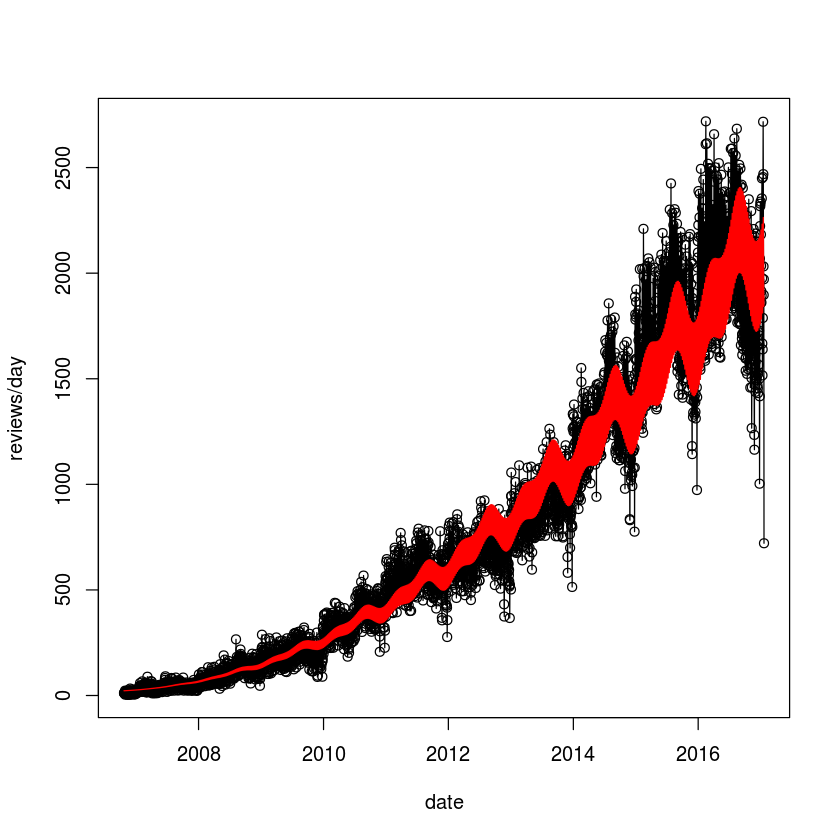

In [15]:
# fit function to review intensity
x = perDay$day
y = perDay$freq
polyModel = lm(y ~ I(x)+I(x^2)+I(x^2*sin(2*x*pi/7))+I(x^2*sin(2*x*pi/182.5))+I(x^2*sin(2*x*pi/365)), data = perDay)
summary(polyModel)
perDay$fitted = predict(polyModel, data = perDay)
plot(perDay$date, perDay$freq, type = "o", xlab="date", ylab="reviews/day")
lines(perDay$date, perDay$fitted, lwd=1, col = "red")

In [16]:
# check if rate function is different for different cities
review_food = left_join(review_food, biz_food[,c("business_id","state")], by = "business_id")
states = unique(biz_food$state)
rateFuncState = lapply(states, function(st){
  reviewByState = review_food[which(review_food$state == st),]
  perDayState = plyr::count(reviewByState, "date")
  perDayState$date = as.Date(perDayState$date)
  perDayState$day = as.numeric(perDayState$date - min(perDayState$date)) + 1
  perDayState$daydiff = c(0, diff(perDayState$day))
  x = perDayState$day
  y = perDayState$freq
  polyModelState = lm(y ~ I(x)+I(x^2)+I(x^2*sin(2*x*pi/7))+I(x^2*sin(2*x*pi/182.5))+I(x^2*sin(2*x*pi/365)), data = perDayState)
  perDayState$fitted = predict(polyModelState, data = perDayState)
  return(perDayState)
})

In [17]:
rsquared = sapply(states, function(st){
  i = which(states == st)
  perDayState = rateFuncState[[i]]
  x = perDayState$day
  y = perDayState$freq
  polyModelState = lm(y ~ I(x)+I(x^2)+I(x^2*sin(2*x*pi/7))+I(x^2*sin(2*x*pi/182.5))+I(x^2*sin(2*x*pi/365)), data = perDayState)
  return(summary(polyModelState)$r.squared)
})
rsquared

AZ        IL        NC        NV        OH        ON        PA        QC 
0.9442643 0.3781823 0.8794422 0.9414110 0.8581191 0.9023524 0.8737051 0.7746046 
       WI 
0.7492234

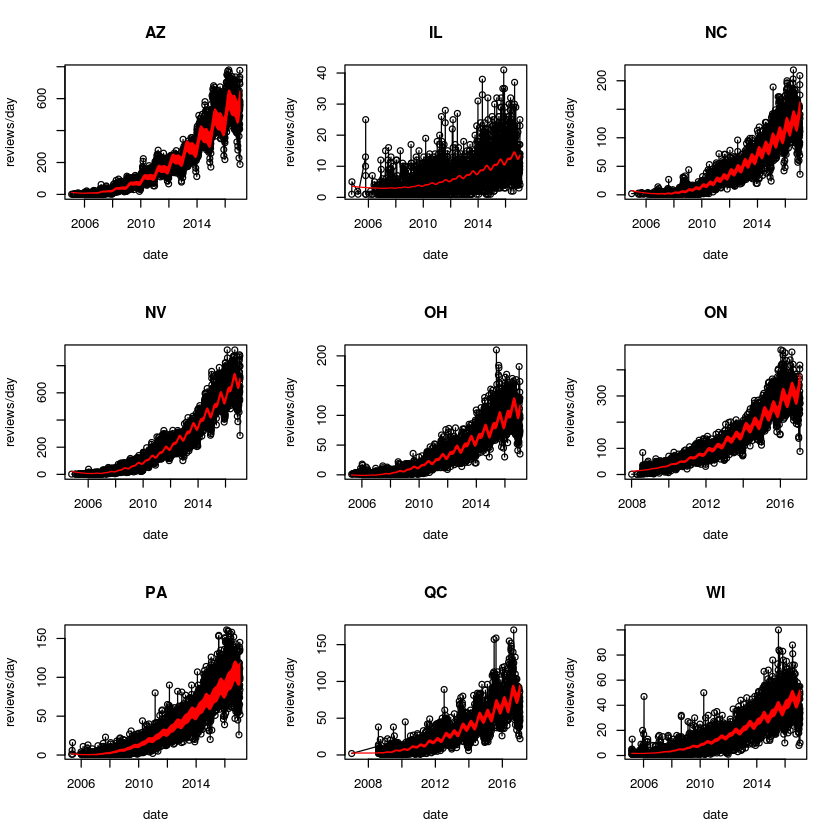

In [21]:
par(mfrow=c(3,3)) 
for (selected_state in 1:9) {
  plot(rateFuncState[[selected_state]]$date, rateFuncState[[selected_state]]$freq, type = "o", 
       xlab="date", ylab="reviews/day", main=states[selected_state])
  lines(rateFuncState[[selected_state]]$date, rateFuncState[[selected_state]]$fitted, lwd=1, col = "red")
}

In [20]:
# join column of when a business opened
survivalData = read.csv(file = "survivalData10.csv")
survivalData = survivalData[,c("business_id", "dF", "avgDB")]
biz_food = left_join(biz_food, survivalData, by = "business_id")
biz_food$opened = as.Date("2017-01-20") - biz_food$dF

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

In [22]:
# calculate cumulative area of rate function
perDay$fitdiff = c(0, diff(perDay$fitted))
perDay$area = 0.5*(2*perDay$fitted - perDay$fitdiff)
perDay$cumarea = cumsum(perDay$area)

In [23]:
# find x such that cumarea(dayopen+x)-cumarea(dayopen)*thinning frac. = 40
expNumDays = function(dateOpened){
  day = as.numeric(as.Date(dateOpened) - cutoff + 1)
  targetThresh = 40
  targetArea = perDay$cumarea[day] + targetThresh*nrow(biz_food)
  return(which.min(abs(perDay$cumarea - targetArea)) - day)
}

In [25]:
# add counter to all reviews (i.e. number of reviews for that business at time of posting)
# review_food = stream_in(file("review_food.json"))
review_food = review_food[which(review_food$date >= cutoff),]
review_food = review_food[with(review_food, order(review_food$business_id, review_food$date)),]
counts = plyr::count(review_food, "business_id")
counter = lapply(counts$freq, function(x) {
  return(c(1:x))
}) 
counter = unlist(counter)
review_food$counter = counter

In [26]:
# add feature: number of days that a business took to reach 40 reviews (NA if it never did)
reached40 = review_food[which(review_food$counter == 40), c("business_id", "date")]
reached40 = left_join(reached40, survivalData[,c(1:2)], by = "business_id")
colnames(reached40)[2:3] = c("reached40","opened")
reached40$opened = as.Date("2017-01-20") - reached40$opened
reached40$days40 = as.numeric(as.Date(reached40$reached40) - reached40$opened)
biz_food = left_join(biz_food, reached40[,c(1,2,4)], by = "business_id")

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

In [27]:
# add feature: expected number of days to reach 40 reviews according to Poisson process
biz_food$opened = as.Date(biz_food$opened)
biz_food$expDays40 = sapply(biz_food$opened, expNumDays)
biz_food$reachedThresh = biz_food$days40 <= biz_food$expDays40

#stream_out(biz_food, file("biz_food_analysis.json"))

Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of short

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumarea - targetArea:
“longer object length is not a multiple of shorter object length”Warning message in perDay$cumar

In [ ]:
str(biz_food)